# Load Dataset
We load the mnist dataset using the keras datasets 

In [3]:
from tensorflow.keras.datasets.mnist import load_data
(X_train,Y_train),(testX,testy)=load_data()

# Test Train Split

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

(X_train, Y_train), (testX, testy) =tf.keras.datasets.mnist.load_data() #Test train spliy
print("x_train shape",X_train.shape)
print("y_train shape",Y_train.shape)
print("testX shape",testX.shape)
print("testy shape",testy.shape)



x_train shape (60000, 28, 28)
y_train shape (60000,)
testX shape (10000, 28, 28)
testy shape (10000,)


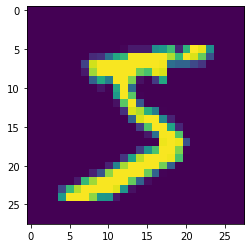

In [5]:
import matplotlib.pyplot as plt
import cv2
plt.imshow(X_train[0])

Generator to genreate new data using XTrain as dataset

In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display

In [7]:
(train_i, train_l), (_, _) = tf.keras.datasets.mnist.load_data()
train_images=train_i.reshape(X_train.shape[0],28,28,1).astype('float32')
#Normalize the image by using the general form ro fit it into [-1,1]
traindata=(train_i-127.5)/127.5

In [8]:
#Assign Batch size 
BUFFER_SIZE= 50000
BATCH_SIZE= 256
train_data=tf.data.Dataset.from_tensor_slices(traindata).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#Generator 

We now define the model for the generator, which is a Dense layer connected with two inverse 2D convolutional layer. The inversing of convolution is done so as to reverse the whole conv 2d process. 

In [9]:
traindata[0].shape

(28, 28)

In [11]:
#Upscaling is done 
#We use the low level resoultion of the image and upscale
from tensorflow.keras import layers
def generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape==(None,7,7,256)
  
  #Upsampling from 4 * 4* 256 to 14*14
  model.add(layers.Conv2DTranspose(128, kernel_size = (5,5),strides=(1,1),padding = 'Same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, kernel_size = (5,5),strides=(2,2),padding = 'Same',use_bias=False))
  assert model.output_shape==(None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #Upscale to 28 * 28 * 1
  model.add(layers.Conv2DTranspose(1, kernel_size = (5,5),strides=(2,2),padding = 'Same',use_bias=False,activation='tanh'))
  assert model.output_shape==(None,28,28,1) 
    #return model.summary()
  return model


In [12]:
generator_model()

Creating Random Sample using Random Noise Z

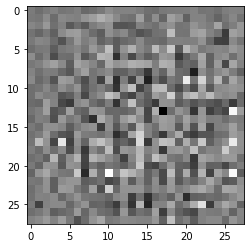

In [13]:
generator=generator_model()
x=tf.random.normal([1,100]) #One dimensional vector with random varibales
gen_img=generator(x,training=False)
plt.imshow(gen_img[0, : , :, 0],cmap='gray')

#Discriminator

Define a model for discriminator that can get the dataset as input and read the generated image to detect whether the image is fake or not.

In [17]:
def discriminator_model():
  #input will be 28 x 28 
  model1=tf.keras.Sequential()
  model1.add(layers.Conv2D(64, kernel_size = (5,5),strides=(2,2),padding = 'same',input_shape=[28, 28, 1]))
  model1.add(layers.LeakyReLU())
  model1.add(layers.Dropout(0.3))

  model1.add(layers.Conv2D(128, kernel_size = (5,5),strides=(2,2),padding = 'same'))
  model1.add(layers.LeakyReLU())
  model1.add(layers.Dropout(0.3))
  
  model1.add(layers.Flatten())
  model1.add(layers.Dense(1,activation='sigmoid'))

  #model1.build(gen_img.shape)
  #return model1.summary()
  return model1


In [18]:
discriminator=discriminator_model()
deci=discriminator(gen_img)
print(deci)

tf.Tensor([[0.500037]], shape=(1, 1), dtype=float32)


Define the loss as binary cross entropy as loss is given as :
## 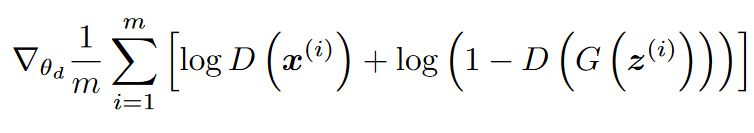

Where , D is discriminator probability and G(Z) is the output of the generator when a noise Z is introduced. D(G(Z)) is the loss that discriminator determines that the sample is fake.


In [19]:
cp=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discloss(real_output, fake_output):
    real_loss = cp(tf.ones_like(real_output), real_output)
    fake_loss = cp(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def genloss(fake_output):
  return cp(tf.ones_like(fake_output),fake_output)

In [22]:
g_optimizer = tf.keras.optimizers.Adam(1e-4)
d_optimizer= tf.keras.optimizers.Adam(1e-4)

# Training to get losses and update it

In [26]:

noise_dim = 100
EPOCHS=10
numberofsamples=20 #we can change it
trains=tf.random.normal([20,100])


In [27]:
@tf.function
def trainstep(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = genloss(fake_output)
      disc_loss = discloss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [41]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      trainstep(image_batch)
    display.clear_output(wait=True)
    generate_and_save(generator,
                             epoch + 1,
                             trains)

    
    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save(generator,
                           epochs,
                           trains)

In [42]:
def generate_and_save(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(5, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5,cmap='gray')
      plt.axis('off')

  plt.savefig('epoch_{:04d}.png'.format(epoch))
  #You can alter this, and can save to drive using os.dir and mention your drive folder as dir
  plt.show()

# Training

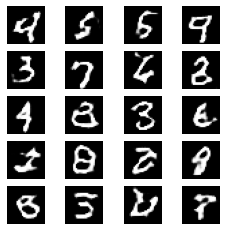

In [43]:
train(train_data,50)